In [1]:
import numpy as np
import torch
import math

from data import *
from loss import *
from experiment_settings import *

## Create Data

In [3]:
training_loader, testing_loader, Us, ws, task_record = create_datasets_2(totalTasks=T, numClusters=L, perCluster=N_L, numSamples=s, baseDim=d, subDim=k, batchSize=int(s/1), sigma=20)

## Context Free Algorithms

### FTL

In [4]:
def FTL(rewards):
    """
    Input:
    rewards - (L, ) numpy array of cumulative rewards indexed by experts
    Output:
    action  - task with leading cumulative reward; ties are broken by choosing an expert uniformly at random
    """
    action = np.random.choice(np.flatnonzero(rewards == rewards.max()))
    return action


### MWA

In [5]:
def MWA(rewards, eta):
    """
    Input:
    rewards - (L, ) numpy array of cumulative rewards indexed by experts
    eta     - randomness hyperparameter
    Output:
    action  - sampled task from exponentially weighted distribution
    """  
    weights = np.exp(eta*(rewards-rewards.max()))
    action_cat = torch.distributions.Categorical(torch.tensor(weights/sum(weights)))
    action = int(action_cat.sample())
    return action

### Exp3

In [6]:
def Exp3(log_weights,eta):
    """
    (p.153 of Lattimore and Szepesvari) 
    Input:
    log_weights - (L, ) numpy array of cumulative S weights
    eta         - randomness hyperparameter
    Output:
    action      - sampled task from exponentially weighted distribution
    probs       - (L, ) numpy array action probability distribution
    """
    
    weights = np.exp(eta*(log_weights-log_weights.max()))
    probs = weights/sum(weights) 
    action_cat = torch.distributions.Categorical(torch.tensor(probs))
    action = int(action_cat.sample())
    return action, probs


### Simulations

In [7]:
def context_free_sim(alg,args):
    """
    Input:
    sequence - sequence of values to predict
    alg      - algorithm used to perform online prediction
    Output:
    regret   - list of regret at every time index
    """
    rewards_actual = np.zeros(L)
    reward_cum = 0
    rewards = []
    regrets = []
    for t in range(T):
        action = alg(np.array(rewards_actual),*args)
        reward_cum += (action == task_record[t])
        rewards.append(reward_cum)
        for i in range(L):
            rewards_actual[i] += (task_record[t] == i)
        regrets.append(max(rewards_actual) - reward_cum)
    return regrets, rewards
regrets_FTL, rewards_FTL = context_free_sim(FTL,[])
regrets_MWA, rewards_MWA = context_free_sim(MWA,[1]) 

In [8]:
def context_free_exp_sim(alg,args):
    """
    Input:
    sequence - sequence of values to predict
    alg      - algorithm used to perform online prediction
    Output:
    regret   - list of regret at every time index
    """
    rewards_actual = np.zeros(L)
    log_weights = np.zeros(L)
    reward_cum = 0
    rewards = []
    regrets = []
    for t in range(T):
        action, probs = alg(log_weights,*args)
        reward = action == task_record[t] 
        reward_cum += reward
        rewards.append(reward_cum)
        for i in range(L):
            rewards_actual[i] += (task_record[t] == i)
            log_weights[i] += 1
            if i == action:
                log_weights[action] += (1-reward)/(probs[action]+eps)

        regrets.append(max(rewards_actual) - reward_cum)
    return regrets, rewards
regrets_Exp3, rewards_Exp3 = context_free_exp_sim(Exp3,[1])

### Plotting

(0.0, 268.8)

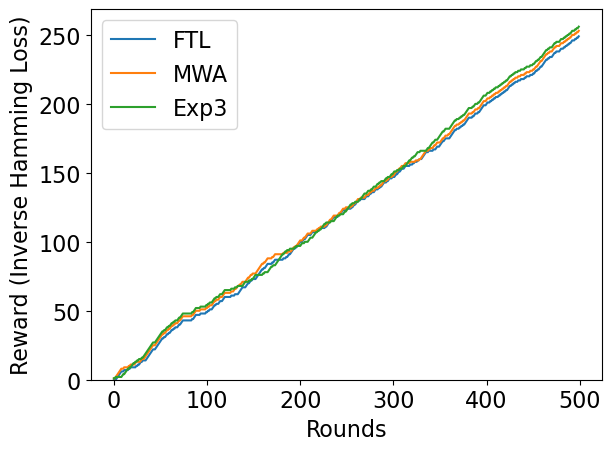

In [9]:
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.autolayout': True})
plt.rcParams.update({'font.size': 16})
all_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
_style = ['-', '--', '-.', ':', '-','--']

x_axis=np.arange(T)
y_lim = None

j4 = plt.figure(8)
plt.plot(rewards_FTL, label = "FTL")
plt.plot(rewards_MWA, label = "MWA")
plt.plot(rewards_Exp3, label = "Exp3")
plt.legend()

plt.xlabel("Rounds")
plt.ylabel("Reward (Inverse Hamming Loss)")
plt.ylim(0, y_lim)

Text(0, 0.5, 'Regret (Inverse Hamming Loss)')

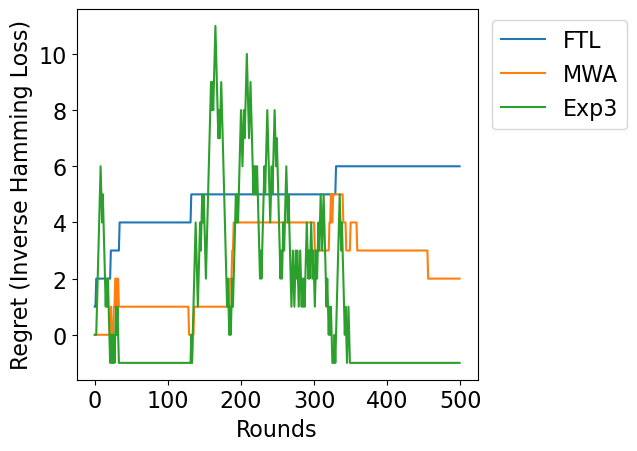

In [10]:
x_axis=np.arange(T)
y_lim = None

j4 = plt.figure(8)
plt.plot(regrets_FTL, label = "FTL")
plt.plot(regrets_MWA, label = "MWA")
plt.plot(regrets_Exp3, label = "Exp3")
plt.legend(loc = "upper right",bbox_to_anchor=(1.4, 1))

plt.xlabel("Rounds")
plt.ylabel("Regret (Inverse Hamming Loss)")

## Context Dependent Algorithms

### C-Exp3

In [11]:
def CExp3(log_weights,context,eta):
    """
    (p.153 of Lattimore and Szepesvari)
    
    Input:
    log_weights - (L, L) numpy array of cumulative S weights (1st index is context, 2nd index is action)
    eta         - randomness hyperparameter
    context     - current context, e.g., subspace identifier
    Output:
    action      - sampled task from exponentially weighted distribution
    probs       - (L, ) numpy array action probability distribution
    """
    action, probs = Exp3(log_weights[context,:],eta)
    return action, probs

### Exp4

In [58]:
def lehmer_code(k, n):
    """Convert integer k to Lehmer code of length n."""
    code = []
    for i in range(n):
        f = math.factorial(n - i - 1)
        d = k // f
        code.append(d)
        k %= f
    return code

def lehmer_to_permutation(code):
    """Convert Lehmer code to permutation."""
    elements = list(range(len(code)))
    perm = []
    for c in code:
        perm.append(elements.pop(c))
    return perm

def get_permutation_index(k, n, j):
    """Returns the j-th element of the k-th permutation of [0, 1   , ..., n - 1]"""
    code = lehmer_code(k,n)
    perm = lehmer_to_permutation(code)
    return perm[j]

def jth_index_permutation_sequence(n, j):
    """Return the sequence of j-th values of permutations of n elements in Lehmer code order."""
    if not (0 <= j < n):
        raise ValueError("j must be between 0 and n-1")
    
    total = math.factorial(n)
    result = []

    for k in range(total):
        code = lehmer_code(k, n)
        perm = lehmer_to_permutation(code)
        result.append(perm[j])
    
    return result

def Exp4(reward_est,probs,context,eta):

    """
    (p.229 of Lattimore and Szepesvari)
    (ECE 8803 L18 Notes) 
    Note: Assumes deterministic policy class
     
    Input:
    reward_est  - importance weighted reward estimates
    probs       - numpy array expert / policy probability distribution
    context     - current context, e.g., subspace identifier
    eta         - randomness hyperparameter
    experts
    Output:
    action      - sampled task from exponentially weighted distribution
    probs       - action probability distribution
    """

    expert_cat = torch.distributions.Categorical(torch.tensor(probs))
    expert = int(expert_cat.sample())
    action = get_permutation_index(expert,L,context)

    policies = jth_index_permutation_sequence(L,context)
    weights = probs*np.exp(eta*(reward_est[policies] - reward_est[policies].max()))
    
    probs = weights/sum(weights) 
    return action, probs

### Simulations (Inverse Hamming / L2 Loss)

#### Losses

In [13]:
def inverse_hamming_loss(X,Y):
    """
    Input:
    X, Y
    Output:
    X ~= Y
    """
    return X != Y

In [14]:
def inverse_l2_loss(context,i):
    """
    Input:
    context - subspace identifier
    i       - task identifier
    Output:
    ||X @ ws[i].T - y||^2, where X,y are generated from subspace Us[context]
    """

    X, y = generate_samples(Us[context],ws[context],s)
    return np.linalg.norm(X@ws[i].T - y)

In [15]:
def inverse_l2_trunc_loss(context,i):
    """
    Input:
    context - subspace identifier
    i       - task identifier
    Output:
    ||X @ ws[i].T - y||^2, where X,y are generated from subspace Us[context]
    """

    X, y = generate_samples(Us[context],ws[context],s)
    return max(0,1-np.linalg.norm(X@ws[i].T - y))

#### C-Exp3

In [16]:
def context_dependent_exp3_sim(alg,reward_func,contexts,args):
    """
    Input:
    sequence - sequence of values to predict
    alg      - algorithm used to perform online prediction
    Output:
    regret   - list of regret at every time index
    """
    rewards_actual = np.zeros(L)
    log_weights = np.zeros((L,L))
    reward_cum = 0
    rewards = []
    regrets = []
    for t in range(T):
        action, probs = alg(log_weights,contexts[t],*args)
        reward = reward_func(task_record[t],action)
        reward_cum += reward
        rewards.append(reward_cum)
        for i in range(L):
            rewards_actual[i] += reward_func(contexts[t],i)
            log_weights[task_record[t],i] += 1
            if i == action:
                log_weights[task_record[t],action] += (1-reward)/probs[action]
        regrets.append(max(rewards_actual) - reward_cum)
    return regrets, rewards, log_weights
regrets_CExp3_hamming, rewards_CExp3_hamming, log_weights_Exp3_hamming = context_dependent_exp3_sim(CExp3,inverse_hamming_loss,task_record,[1])
regrets_CExp3_l2, rewards_CExp3_l2, log_weights_Exp3_l2 = context_dependent_exp3_sim(CExp3,inverse_l2_trunc_loss,task_record,[1])

#### Exp4

In [63]:
def context_dependent_exp4_sim(alg,reward_func,contexts,args):
    """
    Input:
    sequence - sequence of values to predict
    alg      - algorithm used to perform online prediction
    Output:
    regret   - list of regret at every time index
    """
    rewards_actual = np.zeros(L)
    reward_est = np.zeros(L)
    probs = np.ones(math.factorial(L))/math.factorial(L)
    reward_cum = 0
    rewards = []
    regrets = []
    for t in range(T):
        action, probs = alg(reward_est,probs,contexts[t],*args)
        reward = reward_func(task_record[t],action)
        reward_cum += reward
        rewards.append(reward_cum)
        for j in range(L):
            reward_est[j] += reward_func(contexts[t],j)
            if j == action:
                reward_est[action] = reward/(probs[action]+eps)
        regrets.append(max(rewards_actual) - reward_cum)
    return regrets, rewards

regrets_Exp4_hamming, rewards_Exp4_hamming = context_dependent_exp4_sim(Exp4,inverse_hamming_loss,task_record,[1])
#regrets_Exp4_l2, rewards_Exp4_l2 = context_dependent_exp4_sim(Exp4,inverse_l2_loss,task_record,[1])

### Plotting

#### Hamming

(0.0, 517.65)

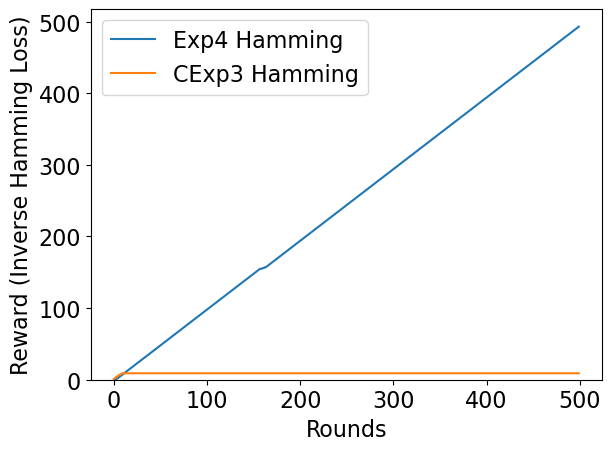

In [64]:
import matplotlib.pyplot as plt

plt.rcParams.update({'figure.autolayout': True})
plt.rcParams.update({'font.size': 16})
all_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
_style = ['-', '--', '-.', ':', '-','--']

x_axis=np.arange(T)
y_lim = None

j4 = plt.figure(8)
plt.plot(rewards_Exp4_hamming, label = "Exp4 Hamming")
#plt.plot(rewards_Exp4_l2, label = "Exp4 L2")
plt.plot(rewards_CExp3_hamming, label = "CExp3 Hamming")
#plt.plot(rewards_CExp3_l2, label = "CExp3 L2")
plt.legend()

plt.xlabel("Rounds")
plt.ylabel("Reward (Inverse Hamming Loss)")
plt.ylim(0, y_lim)

Text(0, 0.5, 'Regret (Inverse Hamming / L2 Loss)')

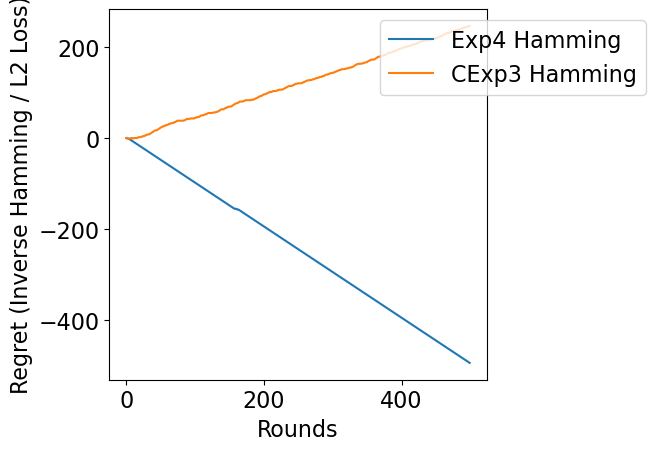

In [65]:
x_axis=np.arange(T)
y_lim = None

j4 = plt.figure(8)
plt.plot(regrets_Exp4_hamming, label = "Exp4 Hamming")
#plt.plot(regrets_Exp4_l2, label = "Exp4 L2")
plt.plot(regrets_CExp3_hamming, label = "CExp3 Hamming")
#plt.plot(regrets_CExp3_l2, label = "CExp3 L2")
plt.legend(loc = "upper right",bbox_to_anchor=(1.45, 1))

plt.xlabel("Rounds")
plt.ylabel("Regret (Inverse Hamming / L2 Loss)")